# Project 2: Kaggle Competition - Image Classification

#### Maximum Points: 100

<div align="center">
    <table>
        <tr><td><h3>Number</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Preparation</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Share TensorBoard Logs</h3></td> <td><h3>10</h3></td></tr>
        <tr><td><h3>3</h3></td> <td><h3>Kaggle Submission Score</h3></td> <td><h3>70</h3></td></tr>
    </table>
</div>


**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab. This is to make sure that students don't copy each other. You are free to take references from any online resource.</font>**

----------

**<font style="color:red">Points to Remember:</font>**

1. You need to achieve **at least `86%`** accuracy on the Public Test leaderboard for **minimum** marks to be awarded.
2. **Maximum** points will be awarded if your Public Test Leaderboard score is **`>=92%`**.
3. In this project for training, you can either use pre-trained models or the ones you create from scratch.

**Kaggle Submission Score Points Distribution**

<div align="center">
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Public Test Set Accuracy</h3></td> <td><h3>Points</h3></td></tr>
        <tr><td><h3>1</h3></td> <td><h3>>= 92%</h3></td> <td><h3>70</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>91%</h3></td> <td><h3>60</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>90%</h3></td> <td><h3>50</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>89%</h3></td> <td><h3>40</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>88%</h3></td> <td><h3>30</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>87%</h3></td><td><h3>20</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>86%</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>< 86%</h3></td> <td><h3>0</h3></td> </tr>
    </table>
</div>

**Note: Percentages will be rounded off to the nearest integer.**

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, PyDataset
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from dataclasses import dataclass
import platform


# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
os.environ["TF_DETERMINISTIC_OPS"] = "1"

2025-10-16 05:11:27.494415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760591487.741556      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760591487.812862      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    
#     physical_devices = tf.config.list_physical_devices("GPU")
#     try:
#         tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     except:
#         # Invalid device or cannot modify virtual devices once initialized.
#         pass

    return

set_seeds()

In [3]:
# Creating a MirroredStrategy for distributed training.
# This strategy effectively replicates the model's layers on each GPU or other available devices,
# syncing their weights after each training step.
DISTRIBUTE_STRATEGY = tf.distribute.MirroredStrategy()

I0000 00:00:1760591503.633851      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760591503.634971      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
# Printing the number of devices that are in sync with the MirroredStrategy.
# This indicates how many replicas of the model are being trained in parallel.
print('Number of devices: {}'.format(DISTRIBUTE_STRATEGY.num_replicas_in_sync))

Number of devices: 2


In [5]:
# If required, update the ROOT_DIR path according to the dataset path.
ROOT_DIR = r"/kaggle/input/opencv-tf-project-2-image-classification-round-4"

IMG_DIR = os.path.join(ROOT_DIR, "sports_images", "all_images")

print("Contents:")
for i in os.listdir(ROOT_DIR):
    if os.path.isdir(os.path.join(ROOT_DIR, i)):
        print(f"\tDirectory: {i}")
    else:
        print(f"\tFile: {i}")

print(f"Total images: {len(os.listdir(IMG_DIR))}")

Contents:
	File: sample_submission.csv
	Directory: sports_images
	File: train.csv
	File: test.csv
Total images: 11146


## <font style="color:red">1 Data Preparation [20 Points]</font>



**There is no separate validation data. You will thus have to create your validation set by dividing the train data into train and validation data. Usually, we do an 80:20 ratio for train and validation, respectively.**

In this section, you can either the `Sequence` class or `tf.data` API or `image_dataset_from_directory` or any other method to create training and validation data generators.



For example:

```python
class SportsClassificationDataset(Sequence):

    def __init__(self, *args):
        ...
        ...

    def __getitem__(self, idx):
        ...
        ...
    def __len__(self):
        ...
        ...
    def on_epoch_end(self):
        ...
        ...
    
```

```python
def get_dataset(args1, *agrs):
    ...
    return train_dataset, test_dataset
```

In [6]:
class SportsClassificationDataset(PyDataset):

    def __init__(self, img_dir, image_size=(224, 224, 3), batch_size = 32, csv_file = None, data_augmentation=False, **kwargs):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.csv_file = csv_file
        self.data_augmentation = data_augmentation

        # Labels and images
        self.unique_labels =  sorted(self.csv_file['CLASS'].unique())
        self.num_class = len(self.unique_labels)
        self.class_indices = {label: idx for idx, label in enumerate(self.unique_labels)}
        #ids_labels = [self.unique_labels.index(lab) for lab in self.csv_file['CLASS'].values
        self.labels_raw = self.csv_file['CLASS'].map(self.class_indices).values
        self.one_hot = tf.keras.utils.to_categorical(self.labels_raw, self.num_class)
        self.ids_image = self.csv_file['ID'].values
        
        # Shuffle at start
        self.on_epoch_end()
    
        #augmentation 
        if self.data_augmentation:
            self.augmentation = tf.keras.Sequential([
                tf.keras.layers.RandomZoom(0.2),
                tf.keras.layers.RandomContrast(0.2),
                tf.keras.layers.RandomFlip("horizontal"),
            ])
        else:
            self.augmentation = None


    def __getitem__(self, idx):
        bacth_images = self.ids_image[idx * self.batch_size: self.batch_size * (idx + 1)]
        batch_labels = self.one_hot[idx * self.batch_size : self.batch_size * (idx + 1)]

        images = np.zeros((len(bacth_images),) + (self.image_size), dtype="float32")
        labels = np.zeros((len(bacth_images),) + (self.num_class,), dtype="float32")

        for i, bacth_image in enumerate(bacth_images):
            path_file = os.path.join(self.img_dir, bacth_image)
            if not os.path.exists(path_file):
                continue
            
            try:
                img = tf.io.read_file(path_file)
                img = tf.image.decode_jpeg(img, channels=3)
                img = tf.image.resize(img, self.image_size[:2])
                img = tf.image.convert_image_dtype(img, tf.float32)

                if self.augmentation:
                    img = tf.expand_dims(img, axis=0)
                    img = self.augmentation(img)
                    img = tf.squeeze(img, axis=0)

                # Apply le preprocess_input (important for VGG16)
                img = preprocess_input(img)
                images[i] = img.numpy() 
                labels[i] = batch_labels[i]
                
            except Exception as e:
                print(f"Error loading image {path_file}: {e}")
                continue

        return images, labels


    def __len__(self):
        return int(np.ceil(len(self.ids_image)/ self.batch_size))

    def on_epoch_end(self):
        # Shuffle to each epoch
        indices = np.arange(len(self.ids_image))
        np.random.shuffle(indices)
        self.ids_image = self.ids_image[indices]
        self.one_hot = self.one_hot[indices]


In [7]:
def parse_image(img_path, label, img_dir, image_size):
    img_path = tf.strings.join([img_dir, img_path], separator=os.sep)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size[:2])
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, label

def get_train_dataset(csv_file, img_dir, image_size=(224, 224, 3), batch_size=32, data_augmentation=False, cache=True):
    # Prepare label encoding
    labels = sorted(csv_file['CLASS'].unique())
    label_to_index = {label: i for i, label in enumerate(labels)}
    label_ids = csv_file['CLASS'].map(label_to_index).values
    one_hot_labels = tf.keras.utils.to_categorical(label_ids, len(labels))

    img_paths = csv_file['ID'].values

    # Create tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, one_hot_labels))
    dataset = dataset.map(lambda x, y: parse_image(x, y, img_dir, image_size), num_parallel_calls=tf.data.AUTOTUNE)

    if data_augmentation:
        augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomZoom(0.2),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomFlip("horizontal")
        ])
        dataset = dataset.map(lambda x, y: (augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
            
    if cache:
        dataset = dataset.cache()  # Cache images in memory (or pass a filename to cache to disk)

    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [8]:
def get_dataset(img_dir = None, image_size= (224, 224, 3), 
                batch_size = 32, train_csv ="train.csv", test_csv = "test.csv", augmentation = True):

    train_path = os.path.join(img_dir,train_csv)
    image_path = IMG_DIR
    train_df = pd.read_csv(train_path)

    # Split train / validation
    #half_df = train_df.sample(frac=0.3, random_state=42)

    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

    train_dataset = SportsClassificationDataset(img_dir = image_path, 
                                image_size = image_size, 
                                batch_size = batch_size, 
                                csv_file = train_df,
                                data_augmentation = augmentation)

    valid_dataset = SportsClassificationDataset(img_dir = image_path, 
                            image_size = image_size, 
                            batch_size = batch_size, 
                            csv_file = val_df)

    train_dataset = (train_dataset, valid_dataset)

    def transform_data(filename):
        img = tf.io.read_file(filename) 
        img = tf.image.decode_jpeg(img, channels=3)  
        img = tf.image.resize(img, image_size[:2])
        img = preprocess_input(img)
        return img


    test_path = os.path.join(img_dir, test_csv)
    test_filename = pd.read_csv(test_path)['ID'].unique()
    test_data = [os.path.join(image_path, fname) for fname in test_filename]
    filename_ds = tf.data.Dataset.from_tensor_slices(test_data)
    test_dataset = filename_ds.map(transform_data)

    test_dataset = test_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    test_dataset = (test_dataset, test_filename)
        
    return train_dataset, test_dataset

In [9]:
def deprocess_vgg16(img, tensor = True):
    if tensor:
        img = img.numpy()
    img[..., 0] += 103.939  # B
    img[..., 1] += 116.779  # G
    img[..., 2] += 123.68   # R
    img = img[..., ::-1]    # Convert BGR to RGB
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img
    
def show_images(dataset, label = False, row = 3, col = 8, batch_size = 32):
    
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(20, 10))
    
    for i in range(row):
        for  j in range(col):
            batch = np.random.randint(0, len(dataset))
            sample = np.random.randint(0, batch_size)
            ax[i][j].axis('off')

            if label == True:
                idx = np.argmax(dataset[batch][1][sample])
                ax[i][j].set_title(dataset.unique_labels[idx])
                image = dataset[batch][0][sample]
                image = deprocess_vgg16(image, False)
            else:
                
                #for idx, data in enumerate(dataset.take(15)):
                batch = next(iter(dataset))
                image = deprocess_vgg16(batch[sample])
                    
            ax[i][j].imshow(image, aspect='equal')
    
    plt.show()

## 2 Configuration 

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfig:
    BATCH_SIZE: int = 10
    EPOCHS: int = 10
    LEARNING_RATE: float = 0.1
    use_multiprocessing: bool = False
    num_workers: int = 4
    ...
    ...
```

```python
@dataclass
class DatasetConfig:
    DATA_ROOT: str = r"../input/opencv-TF-course-project-2-image-classification/sports_images/all_images"
    DATA_SHAPE: tuple = (224, 224, 3)
    NUM_CLASSES: int = 4
```

In [10]:
@dataclass
class TrainingConfig:
    LEARNING_RATE : float =  0.0004 #0.005
    BATCH_SIZE : int = 32 * DISTRIBUTE_STRATEGY.num_replicas_in_sync
    NUM_EPOCH : int = 50

    # For tensorboard logging and saving checkpoints
    root_log_dir = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_initial = "version_0"

    # Use multiprocessing during training.
    use_multiprocessing: bool = True if platform.system() == "Linux" else False
        
    # Number of workers to use for training.
    num_workers: int = 4

In [11]:
@dataclass
class DatasetConfig:
    DATA_ROOT: str = r"/kaggle/input/opencv-tf-project-2-image-classification-round-4"
    DATA_SHAPE: tuple = (224, 224, 3)
    NUM_CLASSES: int = 73

    CLASS_LABELS = sorted(pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))['CLASS'].unique())

In [12]:
train_ds, test_ds = get_dataset(img_dir = DatasetConfig.DATA_ROOT, 
                                image_size = DatasetConfig.DATA_SHAPE, 
                                batch_size= TrainingConfig.BATCH_SIZE, 
                                train_csv ="train.csv", test_csv = "test.csv", 
                                augmentation = False)

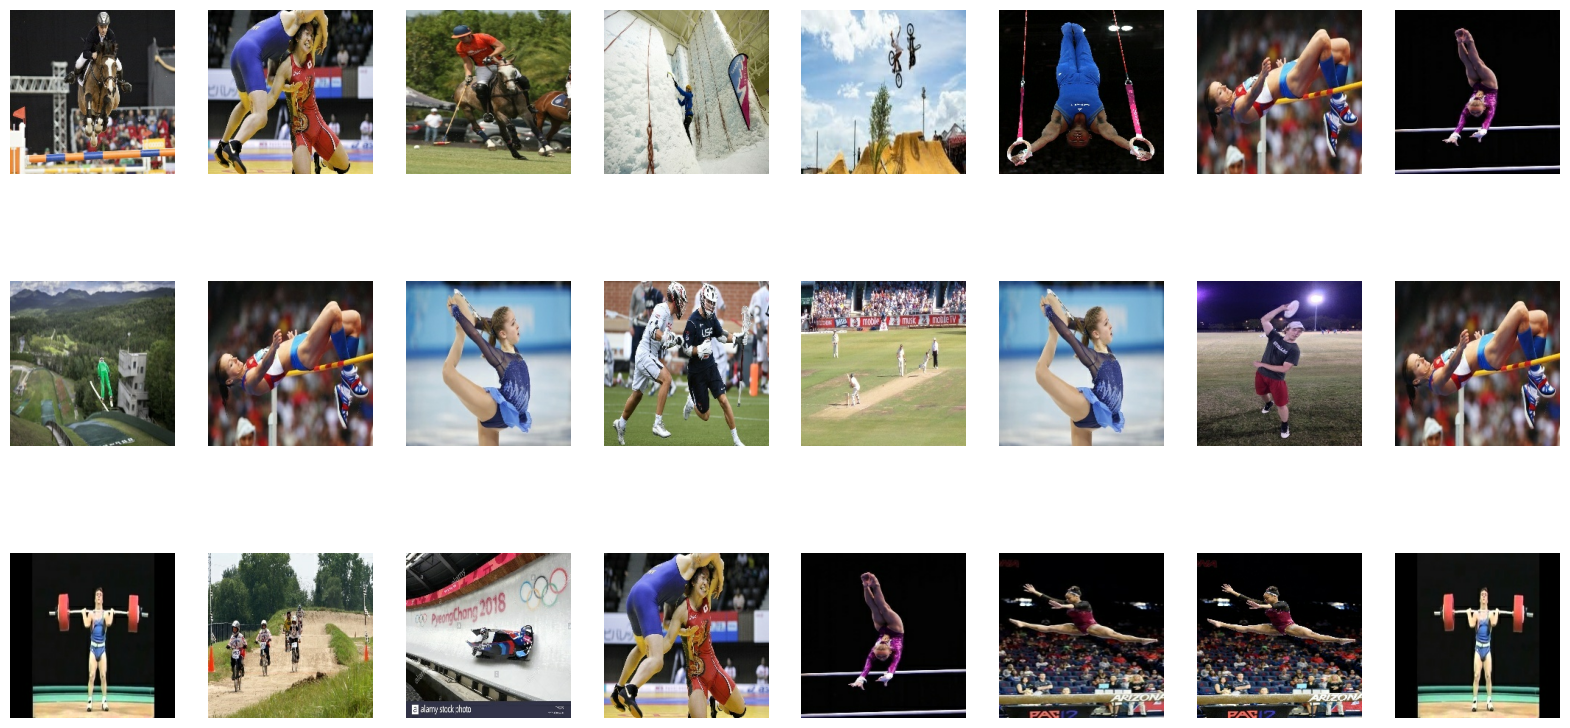

In [13]:
show_images(test_ds[0], label = False, row = 3, col = 8, batch_size = 32)

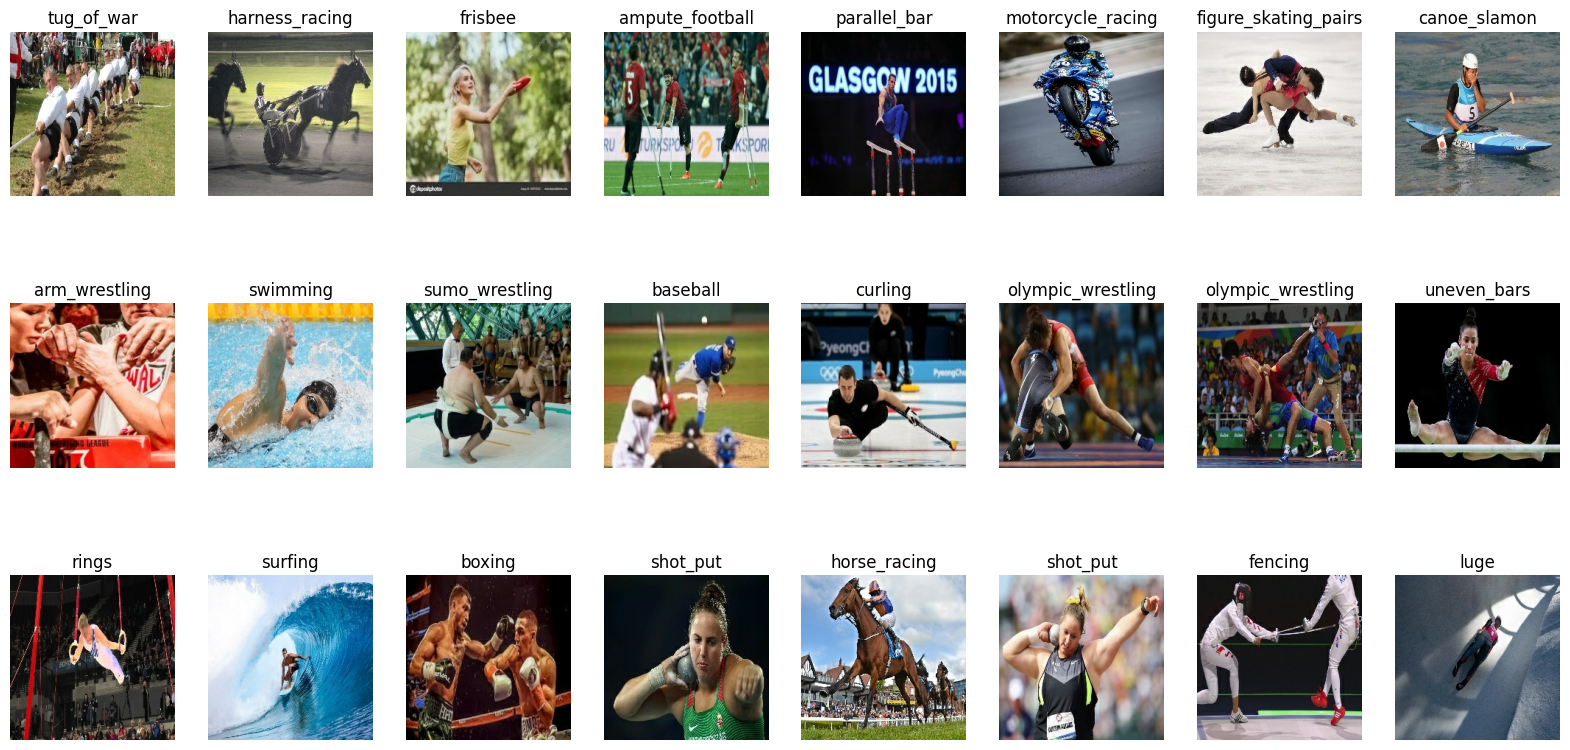

In [14]:
show_images(train_ds[0], label = True, row = 3, col = 8, batch_size = 5)

## 3 Model



**Define your models here.**


```python
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    Rescaling
)


def create_model(num_classes=73, input_shape=(224, 224, 3), name="Dummy_Model"):
    ...
    ...
    ...
    
    # return your model
    return model
  
```

    regularizer  = tf.keras.regularizers.l1_l2(l1=0.0004, l2=0.006)
    input_layer = Input(shape = input_shape)

    rescaled = Rescaling(1./255)(input_layer)

    conv1 = Conv2D(32, 3, activation = 'relu',  padding='same')(rescaled)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D()(bn1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding='same')(pool1)
    bn2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, activation = 'relu', padding='same')(bn2)
    pool2 = MaxPooling2D()(bn2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding='same')(pool2)
    bn3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, 3, activation = 'relu', padding='same')(bn3)
    bn3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D()(bn3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding='same')(pool3)
    bn4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation = 'relu', padding='same')(bn4)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D()(bn4)
    pool4 = MaxPooling2D()(pool4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding='same')(pool4)
    bn5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation = 'relu', padding='same')(bn5)
    bn5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation = 'relu', padding='same')(bn5)
    bn5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D()(bn5)

    flatten = GlobalAveragePooling2D()(pool5)
    flatten = Flatten()(flatten)
    dense1 = Dense(128, activation = 'relu', kernel_regularizer=regularizer)(flatten)
    #drop1 =  Dropout(0.7)(dense1)
    #dense2 = Dense(512, activation = 'relu', kernel_regularizer=regularizer)(drop1)
    #drop2 =  Dropout(0.6)(dense1) #7
    output_layer = Dense(num_classes, activation = 'softmax')(dense1)

    model = Model(input_layer,  output_layer, name = name)

In [15]:
from tensorflow.keras import Model, Input, layers, regularizers
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    Rescaling
)

def get_model(num_classes=73, input_shape=(224, 224, 3), name="Sport_Model"):

    # Load the VGG16 model
    vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in vgg16_model.layers:
        layer.trainable = False
    
    input_tensor = layers.Input(shape=(224, 224, 3))
    x = vgg16_model(input_tensor)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L2(0.005))(x)
    x = layers.Dropout(0.3)(x)
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

In [16]:
def get_callbacks(training_config = TrainingConfig(),
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='min'):

    # Early stopping
    earlystopping = tf.keras.callbacks.EarlyStopping(
        monitor= 'val_loss',
        patience=5,
        verbose=1,
        mode=mode,
        restore_best_weights=save_best_only,
    )

    checkpoint_filepath = training_config.checkpoint_path
    
    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.ckpt")
    else:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.keras")


    #Model Checkpoint
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor='val_loss',
        save_best_only=save_best_only,
        save_weights_only=save_weights_only,
        mode=mode,
        save_freq='epoch',
        initial_value_threshold=None
    )

    #tensorboard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=training_config.log_dir,
        histogram_freq=10,
        write_graph=True,
        update_freq="epoch",
        write_images=False,
    )

    return [tensorboard_callback, model_checkpoint, earlystopping]

In [17]:
def setup_log_directory(training_config=TrainingConfig()):

    get_number = lambda path: path.replace(".keras", "").replace("version_", "")

    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(get_number(file)) for file in os.listdir(training_config.root_log_dir)]

        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers) 

        # New version name
        version_name = f"version_{last_version_number + 1}"
        
    else:
        version_name = training_config.log_dir


    # Update the training config default directory 
    training_config.log_dir = os.path.join(training_config.root_log_dir, version_name)
    training_config.checkpoint_path = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(training_config.log_dir, exist_ok = True)
    os.makedirs(training_config.checkpoint_path, exist_ok = True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_path}")

    return training_config, version_name

In [18]:
def train_model(dataset_config = DatasetConfig(),
               train_config = TrainingConfig,
               data_augmentation = True,
               print_summary = False):

    # Get the data
    train_ds, _ = get_dataset(img_dir = dataset_config.DATA_ROOT, 
                                image_size = dataset_config.DATA_SHAPE, 
                                batch_size= TrainingConfig.BATCH_SIZE, 
                                train_csv ="train.csv", test_csv = "test.csv", 
                                augmentation = True)
    
    # Adataptive learning rate 
    lr_schedule_expo = tf.keras.optimizers.schedules.ExponentialDecay(
        TrainingConfig.LEARNING_RATE,
        decay_steps=10000,
        decay_rate=0.85
    )
    
    lr_schedule_inv = tf.keras.optimizers.schedules.InverseTimeDecay(
        TrainingConfig.LEARNING_RATE,
        decay_steps = 7.0,
        decay_rate = 0.5
    )

    # Get Model
    model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=lr_schedule_inv, name="Sport_Model")

    # Optimizer with decays learning rate
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
        loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"])

    if print_summary:
        model.summary()
    
    # Get training callbacks
    callbacks = get_callbacks(training_config)
    
    training_results = model.fit(train_ds[0],  
                    batch_size=TrainingConfig.BATCH_SIZE,
                    epochs=TrainingConfig.NUM_EPOCH, 
                    callbacks=callbacks,
                    validation_data=train_ds[1],
                    #workers=TrainingConfig.num_workers,
                    #use_multiprocessing=TrainingConfig.use_multiprocessing
                   )

    return model, training_results

## <font style="color:red">4 Share TensorBoard Logs [10 Points]</font>

**Note:** In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

## 4 Training and Loss and Accuracy Plot

In [19]:
training_config = TrainingConfig()

# Tensorboard Log and model checkpoint Setup.
training_config, current_version_name = setup_log_directory(training_config)

model, train_model = train_model(dataset_config = DatasetConfig(),
               train_config = TrainingConfig,
               data_augmentation = True,
               print_summary = True)

Logging at: Logs_Checkpoints/Model_logs/version_0
Model Checkpoint at: Logs_Checkpoints/Model_checkpoints/version_0
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 73)                  │          37,449 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,277,449 (58.28 MB)

 Trainable params: 562,761 (2.15 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/40


I0000 00:00:1760591554.645520     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


126/126 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.0692 - loss: 9.0231 - val_accuracy: 0.4948 - val_loss: 4.5730
Epoch 2/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.3353 - loss: 4.9250 - val_accuracy: 0.6726 - val_loss: 3.4414
Epoch 3/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.5275 - loss: 3.8648 - val_accuracy: 0.7459 - val_loss: 2.9306
Epoch 4/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.6365 - loss: 3.2572 - val_accuracy: 0.7823 - val_loss: 2.5959
Epoch 5/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.6876 - loss: 2.8760 - val_accuracy: 0.8062 - val_loss: 2.3374
Epoch 6/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.7442 - loss: 2.5229 - val_accuracy: 0.8231 - val_loss: 2.1657
Epoch 7/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.7621 - loss: 2.3206 - val_accuracy: 0.8386 - val_loss: 1.9817
Epoch 8/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.7885 - loss: 2.1127 - val_accuracy: 0.836

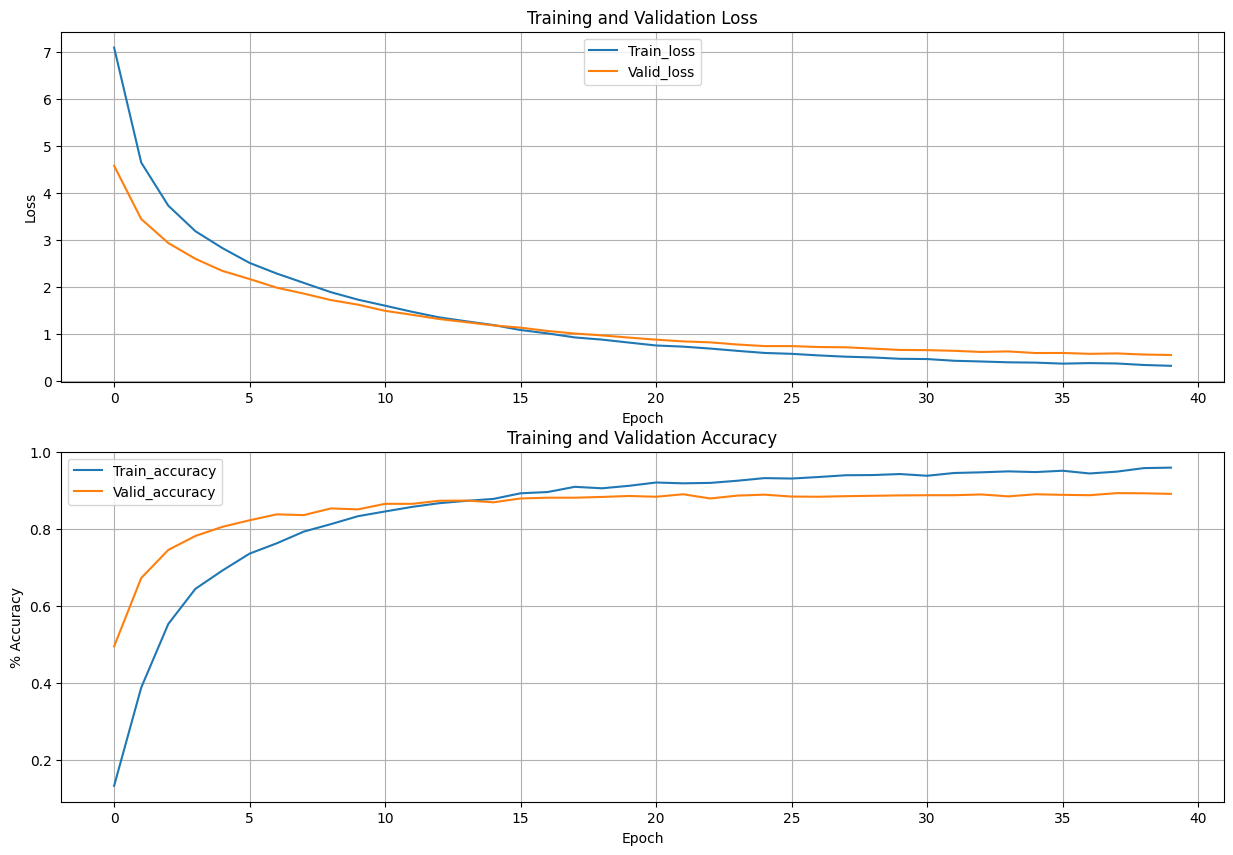

In [20]:
def plot_metrics(train_model = train_model, 
                 loss_legend_loc="upper center",
                 acc_legend_loc="upper left"):

    history = train_model.history
    keys_accuracy = list(history.keys())

    # plot parameter
    plt.rcParams["figure.figsize"] = (15, 10)
    fig = plt.figure()
    fig.set_facecolor("white")

    # Loss Plots
    plt.subplot(2, 1, 1)
    train_loss_range = range(len(history[keys_accuracy[0]]))
    plt.plot(train_loss_range, history[keys_accuracy[1]], label="Train_loss")
    plt.plot(train_loss_range, history[keys_accuracy[3]],  label="Valid_loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.title("Training and Validation Loss")
    plt.legend(loc=loss_legend_loc)

    # Accuracy Plots
    plt.subplot(2, 1, 2)
    plt.plot(history[keys_accuracy[0]], label="Train_accuracy")
    plt.plot(history[keys_accuracy[2]],  label="Valid_accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('% Accuracy')
    plt.grid()
    plt.legend(loc=acc_legend_loc)
    plt.title("Training and Validation Accuracy")
    plt.show()

plot_metrics(train_model)

In [21]:
#%load_ext tensorboard
#%tensorboard --logdir ./Logs_Checkpoints/Model_logs

In [22]:
#!tensorboard --logdir ./Logs_Checkpoints/Model_logs

In [23]:
#!kill 148
#%tensorboard --logdir ./Logs_Checkpoints/Model_logs --port=1024

In [24]:
#%reload_ext tensorboard 

## <font style="color:red">5 Kaggle Submission Score [70 Points]</font>


**For full points, you need a acheive atleast `92%` accuracy on the Public Test Leaderboard. If accuracy is less than `86%`, you gain no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**

<a href="https://www.kaggle.com/competitions/opencv-tf-project-2-image-classification-round-4" target="_blank">Kaggle Competition Link</a>

In [25]:
def recreate_model(path, load_weights = False, config=DatasetConfig(), **kwargs):

    if load_weights:

        model = model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE, name="Sport_Model")

        #loads trained models best weights
        path = os.path.join(path, "model.ckpt")
        model.load_weights(path).expect_partial()
    else:
        path = os.path.join(path, "model.keras")
        model = tf.keras.models.load_model(path, **kwargs)
        
    model.summary()
    return model

In [26]:
load_version = current_version_name
checkpoint_path = os.path.join(training_config.root_checkpoint_dir, load_version)

save_model = recreate_model(checkpoint_path, load_weights = False, config=DatasetConfig())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 73)                  │          37,449 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,402,973 (62.57 MB)

 Trainable params: 562,761 (2.15 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,125,524 (4.29 MB)

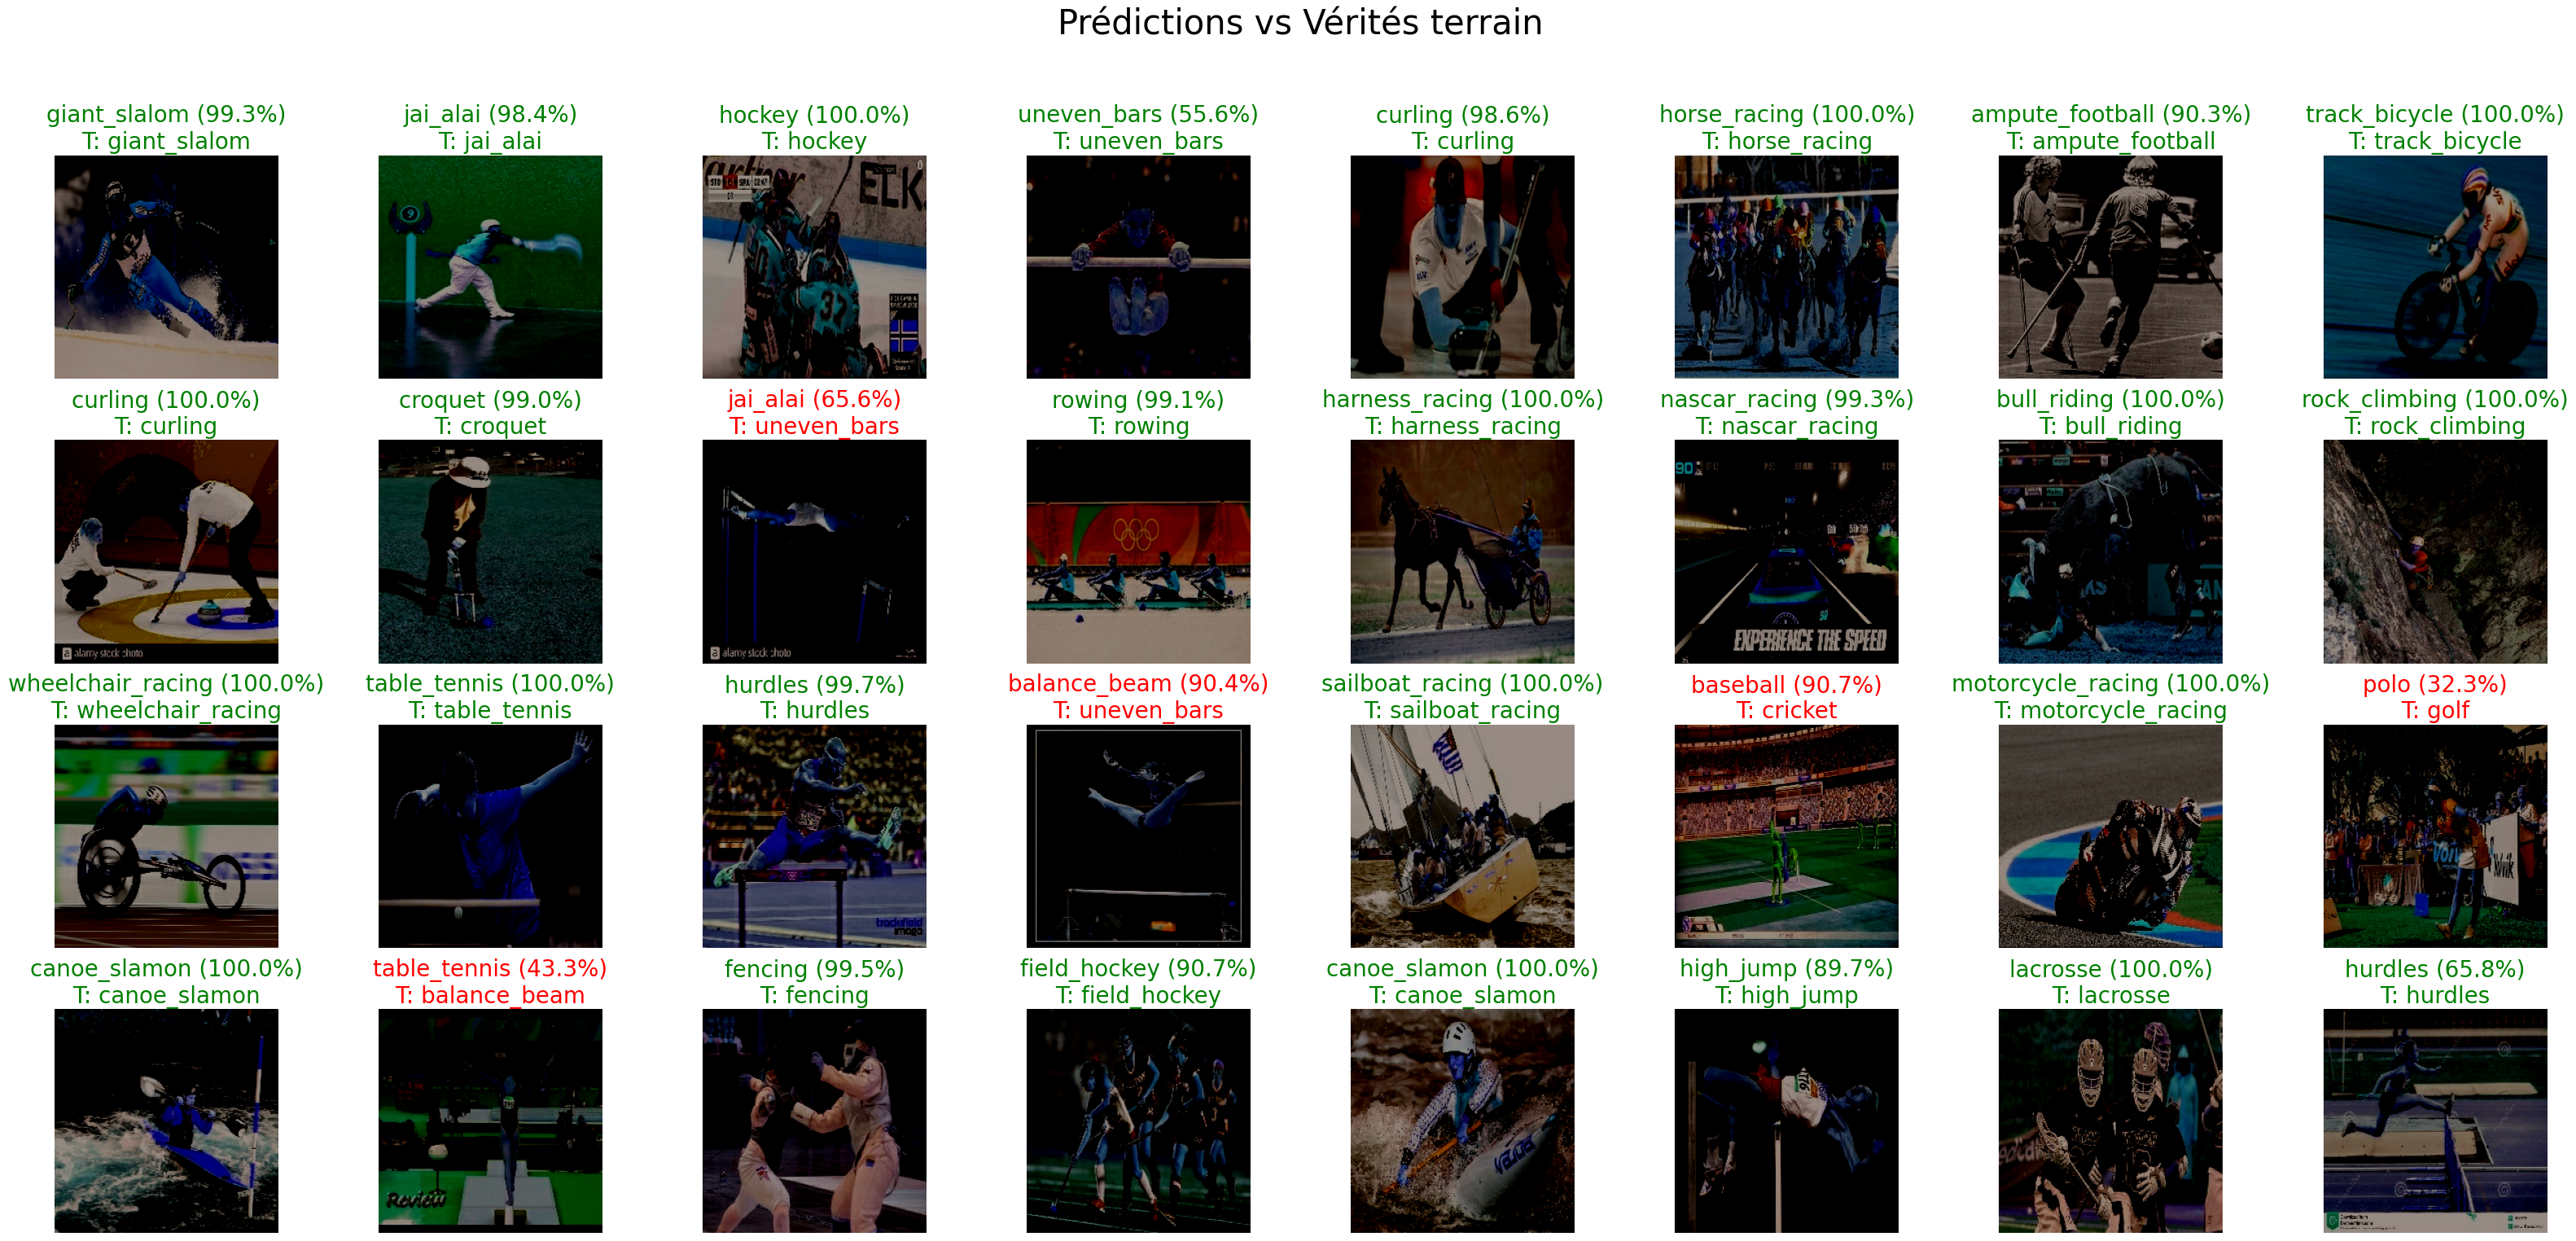

In [27]:
valid = train_ds[1]
all_label = DatasetConfig.CLASS_LABELS
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(32, 16))
fig.suptitle("Prédictions vs Vérités terrain", fontsize=30)

colors = {'correct': 'green', 'incorrect': 'red'}
idx = 0  # compteur global

for images, labels in valid:
    batch_predict = save_model.predict_on_batch(images)
    probs = np.max(batch_predict, axis=-1)
    ground_truths = np.argmax(labels, axis=-1)
    predictions = np.argmax(batch_predict, axis=-1)

    for i in range(32):
        label_pred = all_label[predictions[i]]
        label_true = all_label[ground_truths[i]]
        prob = round(probs[i] * 100, 1)
        color = colors['correct'] if label_pred == label_true else colors['incorrect']

        img = images[i] / 255.0
        ax = axes[idx // 8, idx % 8]
        ax.imshow(img)
        ax.set_title(f"{label_pred} ({prob}%)\nT: {label_true}", color=color, fontsize=20)
        ax.axis("off")
        idx += 1

    break  

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [28]:
submit = {'ID' : [], 'CLASS' : []}

images, labels =  test_ds
label_index = 0
for image in images:
    bacth_predict = save_model.predict_on_batch(image)
    indexs = np.argmax(bacth_predict, axis=-1)

    for i, index in enumerate(indexs):
        label_predict = all_label[index]
        image_id = labels[label_index]
        submit['CLASS'].append(label_predict)
        submit['ID'].append(image_id)
        label_index += 1
        
os.makedirs("Submission", exist_ok = True)
path_save_csv = os.path.join('/kaggle/working/', 'submission.csv')
submit_df = pd.DataFrame(submit)
submit_df.to_csv(path_save_csv, index=False)

**Please share your profile link, user id and score achieved.**

1. **URL:**
2. **Profile Name:** 
3. **Points Scored:**

**Upon completing the project,  <font style="color:red">upload the notebook on the portal for feedback.</font>**


**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab.</font>**